<a href="https://colab.research.google.com/github/KArimCHidekh/Bert-NLP/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers==4.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data_complaint = pd.read_csv('complaint1700.csv')
data_non_complaint = pd.read_csv('noncomplaint1700.csv')
#tweets = pd.read_csv('Tweets.csv')

#tweets.sample(5)
#test_data2 = pd.read_csv('sentiment_tweets3.csv')

#test_data2['label (depression result)'].value_counts()

#list(test_data2.columns)

In [ ]:
data_complaint['label'] = 0
data_non_complaint['label'] = 1

# Concatenate complaining and non-complaining data
data = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)

# Drop 'airline' column
#data.drop(['airline'], inplace=True, axis=1)

# Display 5 random samples
data.sample(20)

,id,airline,tweet,label
2158,38377,American,@oldpathsjournal @AmericanAir You poor thing! ...,1
1331,101278,SouthWest,"Hey @SouthwestAir, 128 planes with ""missed"" MX...",0
508,31199,United,@united Friend called for change of flight. Un...,0
1085,39588,SouthWest,@SouthwestAir I still haven't heard back from ...,0
1839,15551,American,@laurahorn10 @AmericanAir Ooo she mad,1
2529,77551,JetBlue,"@JetBlue so yr message is ""next time we do a p...",1
1273,64297,United,@united shame on you for leaving that dog out ...,0
768,8379,SouthWest,"@Feelmyflow @SouthwestAir @AlaskaAir agreed, I...",0
3296,157938,JetBlue,@JetBlue handling compliments better than the ...,1
2252,47427,AlaskaAir,I find it ironic that we arrived at gate L8. B...,1


In [ ]:
tweets = pd.read_csv('Tweets.csv')
tweets.sample(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11715,567802255215460353,negative,1.0000,Customer Service Issue,0.6498,US Airways,NaN,Ltos5363,NaN,0,@USAirways If you can waive a fee at time of ...,NaN,2015-02-17 13:46:21 -0800,"South Shore, MA",Eastern Time (US & Canada)
6140,568187725834289152,neutral,1.0000,NaN,NaN,Southwest,NaN,Armywives101,NaN,0,@SouthwestAir Working on a piece about militar...,NaN,2015-02-18 15:18:04 -0800,Fayetteville North Carolina,Eastern Time (US & Canada)
1727,569615215144226816,positive,0.6497,NaN,0.0000,United,NaN,steve__chin,NaN,0,"@united thx off the response, finally got thro...",NaN,2015-02-22 13:50:24 -0800,San Francisco Bay Area,Pacific Time (US & Canada)
9634,569760267485122560,negative,1.0000,Late Flight,0.6660,US Airways,NaN,JackieSeigel,NaN,0,@USAirways pls get me back to Tallahassee:( no...,NaN,2015-02-22 23:26:48 -0800,NaN,Central Time (US & Canada)
5653,568832907525152769,negative,1.0000,Customer Service Issue,0.6735,Southwest,NaN,noli528,NaN,0,@SouthwestAir Flight to Nashville was Cancelle...,NaN,2015-02-20 10:01:48 -0800,"Nashville, TN",Central Time (US & Canada)
2220,569309296023998464,negative,1.0000,longlines,0.6907,United,NaN,ZachAlpert,NaN,0,"@united instead of be told when we board, we h...",NaN,2015-02-21 17:34:48 -0800,"Chicago, IL",Central Time (US & Canada)
11780,567762685200228352,neutral,0.6845,NaN,0.0000,US Airways,NaN,Eagles_SAB,NaN,0,"@USAirways Darn it, first in line for no upgra...",NaN,2015-02-17 11:09:07 -0800,"Philadelphia, PA",Central Time (US & Canada)
4815,569701794714128384,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,zarrylarou,NaN,0,".@SouthwestAir glad you appreciate it, it’ll b...",NaN,2015-02-22 19:34:27 -0800,NY,Eastern Time (US & Canada)
2905,568835255722860544,positive,1.0000,NaN,NaN,United,NaN,lcadler,NaN,0,@united Baggage check in and in flight crew th...,NaN,2015-02-20 10:11:08 -0800,NaN,Pacific Time (US & Canada)
4907,569666470482804737,negative,1.0000,Can't Tell,1.0000,Southwest,NaN,k_wasie,NaN,0,@SouthwestAir wifi is the worst $8 investment ...,NaN,2015-02-22 17:14:05 -0800,The happiest place on Earth!,Eastern Time (US & Canada)


In [ ]:
data2 = tweets

In [ ]:
tweets = pd.read_csv('Tweets.csv')
tweets.drop('airline', axis=1, inplace=True)
tweets.drop('negativereason', axis=1, inplace=True)
tweets.drop('negativereason_confidence', axis=1, inplace=True)
tweets.drop('airline_sentiment_confidence', axis=1, inplace=True)

tweets.drop('negativereason_gold', axis=1, inplace=True)
tweets.drop('airline_sentiment_gold', axis=1, inplace=True)
tweets.drop('retweet_count', axis=1, inplace=True)
tweets.drop('tweet_coord', axis=1, inplace=True)

tweets.drop('tweet_location', axis=1, inplace=True)
tweets.drop('tweet_created', axis=1, inplace=True)
tweets.drop('user_timezone', axis=1, inplace=True)
tweets.drop('name', axis=1, inplace=True)
#tweets.drop('airline', axis=1, inplace=True)

#tweets.drop('airline', axis=2, inplace=True)

#tweets.drop('',axis=1, inplace=True)

# Check the current list of columns
list(tweets.columns)

['tweet_id', 'airline_sentiment', 'text']

In [ ]:
data2.rename(columns = {'text':'tweet'}, inplace = True)

In [ ]:
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
newdf = data2.query('airline_sentiment == "negative" ')
newdf2 = data2.query('airline_sentiment == "positive" ')
newdf3 = data2.query('airline_sentiment == "neutral" ')


#test_data2 = tweets.query('airline_sentiment == "neutral" ')

In [ ]:
newdf['label'] = 0
newdf2['label'] = 1
newdf3 ['label'] = 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
data2 = pd.concat([newdf, newdf2, newdf3], axis=0).reset_index(drop=True)

In [ ]:
data2.sample(5)

,tweet_id,airline_sentiment,tweet,label
671,569883984190005248,negative,@united 768 SFO to BOS and no internet it is 2...,0
13875,569961481455976449,neutral,@USAirways is there an additional charge for a...,2
14540,569698461911683073,neutral,@AmericanAir she doesn't have Twitter.,2
2876,570257631778107392,negative,@SouthwestAir mins and no answer. My wife and ...,0
1182,569528348126216193,negative,@united any chance you could help rebook?? My ...,0


In [ ]:
newdf = tweets.query('airline_sentiment == "negative" ')
newdf2 = tweets.query('airline_sentiment == "positive" ')
test_data = pd.concat([newdf, newdf2], axis=0).reset_index(drop=True)

test_data.drop('airline_sentiment', axis=1, inplace=True)
test_data.rename(columns = {'text':'tweet'}, inplace = True)
test_data.sample(16)

#test_data['airline_sentiment'].value_counts()

,tweet_id,tweet
3367,569165378359656448,@SouthwestAir this is ridiculous. It's been 2 ...
1809,568905087608881152,@united Existing reservation is fine. I was ta...
7375,570276245960835073,@AmericanAir said that AA does not provide in-...
1878,568848699960332288,@united what I don't understand isn't flight t...
995,569635623348215808,@united seriously what's with the slow #wifi o...
2956,569977223198822400,"@SouthwestAir like kelsey said, really bad spo..."
84,569247769166266368,@VirginAmerica seats in Row 8 don't recline sh...
11353,570016890996666368,@AmericanAir Lady at B1 ABQ for 5347 on 2/23 w...
1964,568793043664560128,@united 2nd time in a row I've been over char...
1287,569438531686424577,@united of course I would like hepl! Are you k...


In [ ]:
import nltk
nltk.download('stopwords')

import re
# Uncomment to download "stopwords"
# nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    # s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    s = re.sub(r'@[A-Za-z0-9]+','',s)
    s = re.sub(r'#' , '',s)
    s= re.sub(r'RT[\s]+','',s)
    s = re.sub(r'https?:\/\/\S+','',s)
    s = re.sub(r'&amp;', '&', s)

    # remove numbers
    s = re.sub(r'\d+', '', s)
    return s


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.model_selection import train_test_split

X = data2.tweet.values
y = data2.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=2022)

In [ ]:
# Print sentence 0
print('Original: ', X[3])
print('Processed: ', text_preprocessing(X[3]))

Original:  @VirginAmerica SFO-PDX schedule is still MIA.
Processed:  sfo-pdx schedule still mia .


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(dt):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in dt:
        
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  
            add_special_tokens=True,        
            max_length=MAX_LEN,                  
            pad_to_max_length=True,         
            #return_tensors='pt',           
            return_attention_mask=True      
            )
        
      
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

   
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
import numpy as np


# Concatenate train data and test data
all_tweets = data2.tweet.values

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
MAX_LEN = max([len(sent) for sent in encoded_tweets])
print('Max length: ', MAX_LEN)

Max length:  67


In [ ]:
MAX_LEN = 68

In [ ]:
# Print sentence 0 and its encoded token ids


token_ids = list(preprocessing_for_bert([X[1]])[0].squeeze().numpy())
print('Original: ', X[1])
print('Token IDs: ', token_ids)

token_ids = list(preprocessing_for_bert([X[20]])[0].squeeze().numpy())
print('Original: ', X[20])
print('Token IDs: ', token_ids)

token_ids = list(preprocessing_for_bert([X[400]])[0].squeeze().numpy())
print('Original: ', X[400])
print('Token IDs: ', token_ids)

token_ids = list(preprocessing_for_bert([X[852]])[0].squeeze().numpy())
print('Original: ', X[852])
print('Token IDs: ', token_ids)



# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  @VirginAmerica and it's a really big bad thing about it
Token IDs:  [101, 1005, 2428, 2502, 2919, 2518, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Original:  @VirginAmerica your airline is awesome but your lax loft needs to step up its game. $40 for dirty tables and floors? http://t.co/hy0VrfhjHt
Token IDs:  [101, 8582, 12476, 27327, 19459, 3791, 3357, 2208, 1012, 1002, 6530, 7251, 8158, 1029, 8299, 1013, 1013, 1012, 2522, 1013, 1044, 2100, 19716, 2546, 2232, 3501, 11039, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Original:  @united @AmericanAir so that's it? It just ends there? Come on! I traveled for literally an extra day and a half because of this!
Token IDs:  [101, 1005, 1029, 4515, 1029, 2272, 999, 6158, 6719, 4469, 2154, 2431, 999, 102, 0, 0, 0, 0, 0,

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 59 µs, sys: 0 ns, total: 59 µs
Wall time: 63.4 µs


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs 

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
import tensorflow
from tensorflow.random import set_seed 

set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
nf = train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.799580   |     -      |     -     |   9.24   
   1    |   40    |   0.638954   |     -      |     -     |   8.92   
   1    |   60    |   0.580435   |     -      |     -     |   9.03   
   1    |   80    |   0.510927   |     -      |     -     |   8.97   
   1    |   100   |   0.541549   |     -      |     -     |   8.85   
   1    |   120   |   0.497838   |     -      |     -     |   8.77   
   1    |   140   |   0.544525   |     -      |     -     |   8.73   
   1    |   160   |   0.507932   |     -      |     -     |   8.70   
   1    |   180   |   0.443446   |     -      |     -     |   8.83   
   1    |   200   |   0.529255   |     -      |     -     |   8.98   
   1    |   220   |   0.475977   |     -      |     -     |   8.79   
   1    |   240   |   0.534094   |     -      |     -     |   8.83   


In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = [] 

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)


In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8881
Accuracy: 77.35%


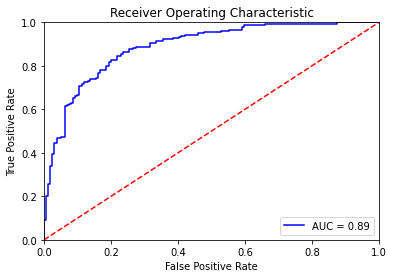

In [ ]:
evaluate_roc(probs, y_val)

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)


In [ ]:
# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.673726   |     -      |     -     |   7.36   
   1    |   40    |   0.551986   |     -      |     -     |   7.06   
   1    |   60    |   0.518128   |     -      |     -     |   7.07   
   1    |   80    |   0.550541   |     -      |     -     |   7.14   
   1    |   100   |   0.443649   |     -      |     -     |   7.18   
   1    |   106   |   0.431475   |     -      |     -     |   1.92   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.323710   |     -      |     -     |   7.61   
   2    |   40    |   0.293927   |     -      |     -     |   7.25   
   2    |   60    |   0.306363   |     -      |     -     |   7.25

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:



probs = bert_predict(bert_classifier, test_dataloader)
threshold = 0.944
postive_prediction = np.where(probs[:, 1] > threshold, 1, 0)
#negative_prediction = np.where(probs[:, 1] > threshold, 0, 1)

print("le nombre des tweets prédits positive: ", postive_prediction.sum())
#print("Le nombre des tweets prédits négative: ", negative_prediction.sum())

le nombre des tweets prédits positive:  2371


In [ ]:
output = test_data2[postive_prediction==1]
list(output.sample(20).text)

['@AmericanAir thanks for getting back to me. how frequently are these weather advisories updated throughout the day?',
 '@SouthwestAir Have a cup coffee and relax while you check out the New Deals and Promotions at Avon, twice a month at Doug @dcoadavon',
 '@united can you please tell me where United flies to from Sydney Australia - pref Asia Pac or US as I have a voucher to redeem.',
 '@JetBlue Thank you ! What about Paris ? Could we arrange something from there ?',
 '@SouthwestAir yes, thank you. Just sent DM.',
 '@SouthwestAir better travel photos:\nMy Kindle e-book Easy Tips guide http://t.co/7dM2J8H97M:\nhttp://t.co/xeDeckGMW5 http://t.co/frGhglMkqF',
 '@VirginAmerica Now, when will we see VirginAmerica come to Philadelphia (PHL).',
 "@AmericanAir We've sent you more info via DM.  I truly hope you resolve this very quickly. #media #filmcrew #cnn #nbc",
 "@JetBlue you're taking me to New Orleans in two weeks so I'll picture that while I shiver #forevercold",
 '@JetBlue Thanks! I j